### aim: 

### date: 

In [50]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [51]:
%reset

In [52]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

### dong comes from here:

https://agupubs.onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1029%2F2006JC004051&file=jgrc10600-sup-0002-ds01.txt

In [66]:
get_nc = True
if get_nc:
    df = pd.read_csv('./Dong2008argo.csv')
    # df.columns.tolist()

    new_df = df[['Month', 'latitude','longitude', 'MLDpd']]

    new_df.rename(columns={'Month ': 'mon'}, inplace=True)
    new_df.rename(columns={'latitude ': 'lat'}, inplace=True)
    new_df.rename(columns={'longitude   ': 'lon'}, inplace=True)
    new_df.rename(columns={'MLDpd     ': 'MLDpd'}, inplace=True)


    df2 = new_df

    savenam1 = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_regridrecalc.nc'
    cdomask = xr.open_dataset(savenam1)
    ds = cdomask.tmask

    mld_stor = np.zeros([12,180,360])

    for m in range(1,13):
        mo_in = m-1
        print(m)
        for lo in range(0,360):
            if lo%60 == 0:
                print(f'---{lo}')
            for la in range(-89,-30,1):

                lo_df = lo+0.5
                la_df = la - 0.5
                w = np.where((ds.lon==lo) & (ds.lat==la_df))
                lon_in = (w[0][0])
                lat_in = (w[1][0])
                # get dataframe loc
                try:
                    tdf = (df2[(df2.Month == m) & (df2.latitude == la_df) & (df2.longitude == lo_df)])
                    MLD = (tdf.MLDpd.values[0])
                    #print(f'{lo_df} ({lon_in}), {la_df} ({lat_in}), {MLD}')
                    mld_stor[mo_in,lat_in,lon_in] = MLD
                except:
                    pass

    yr = 2000
    times = pd.date_range(f"{yr}/01/01",f"{yr+1}/01/01",freq='MS',closed='left')

    savenam = './Dong2008MLD.nc'
    data_vars = {'MLD':(['time_counter', 'lat', 'lon'], mld_stor,
    {'units': 'm',
    'long_name':'mld southern ocean from JGR Dong 2008, sigma 0.03 crit'}),
    }
    # define coordinates
    coords = {'time_counter': (['time_counter'], times),           
    'lat': (['lat'], ds.lat),
    'lon': (['lon'], ds.lon),
    }

    # define global attributes
    attrs = {'made in':'scratch/SOZONE/windAnalyis/oceanFields/observational_MLD.ipynb',
    'desc': 'dong in a netcdf'
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds.to_netcdf(savenam)


1
---0
---60
---120
---180
---240
---300
2
---0
---60
---120
---180
---240
---300
3
---0
---60
---120
---180
---240
---300
4
---0
---60
---120
---180
---240
---300
5
---0
---60
---120
---180
---240
---300
6
---0
---60
---120
---180
---240
---300
7
---0
---60
---120
---180
---240
---300
8
---0
---60
---120
---180
---240
---300
9
---0
---60
---120
---180
---240
---300
10
---0
---60
---120
---180
---240
---300
11
---0
---60
---120
---180
---240
---300
12
---0
---60
---120
---180
---240
---300


In [54]:
w = xr.open_dataset('Dong2008MLD.nc')
w_masked = w.where(w['MLD'] != 0)

In [ ]:
def make_yearlist_uk(yrst, yrend, scen):
    yrs = np.arange(yrst,yrend,1)
    ylist = []
    for i in range(0,len(yrs)):
        y = yrs[i]
        tdir = '/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_gridT_mld/'
        t2 = glob.glob(f'{tdir}/nemo_scen_{scen}_1m_{y}_fy_grid-T.nc')
        ylist.append(t2[0])
    return ylist

def make_yearlist_tom(yrst, yrend, scen, dir1 = '/gpfs/data/greenocean/software/runs/'):
    yrs = np.arange(yrst,yrend,1)
    ylist = []
    for i in range(0,len(yrs)):
        y = yrs[i]
        tdir = f'{dir1}{scen}/'
        t2 = glob.glob(f'{tdir}/ORCA2_1m_{y}0101_{y}1231_grid_T.nc')
        ylist.append(t2[0])
    return ylist

ukesm_mld = xr.open_mfdataset(make_yearlist_uk(2001, 2007, '1A'))
TJ_1AA6_mld = xr.open_mfdataset(make_yearlist_tom(2001, 2007, 'TOM12_TJ_1AA6'))
TJ_1ASA_mld = xr.open_mfdataset(make_yearlist_tom(2001, 2007, 'TOM12_TJ_1ASA'))
ET_SI73_mld = xr.open_mfdataset(make_yearlist_tom(2001, 2007, 'TOM12_TJ_1ASA', dir1 = '/gpfs/home/e031/scratch/'))

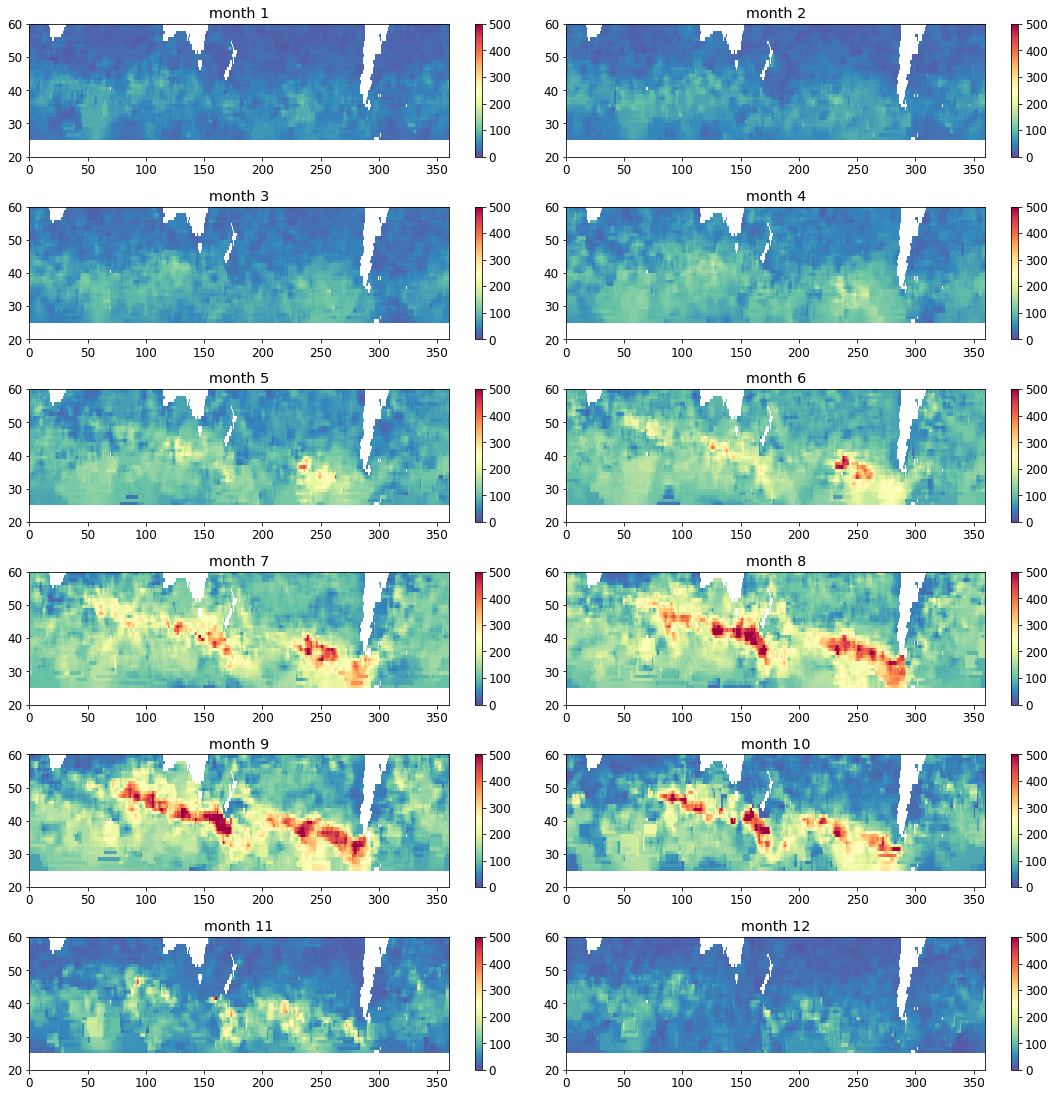

In [55]:


fact = 1.1
fig, axs = plt.subplots(6,2, figsize=(14*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,12):
    q = axs[i].pcolormesh(w_masked.MLD[i,:,:], vmin = 0, vmax = 500, cmap = 'Spectral_r')
    axs[i].set_ylim([20,60])
    axs[i].set_title(f'month {i+1}')
    plt.colorbar(q, ax = axs[i])
    
plt.tight_layout()

### now we want to compare UKESM and TOM to DONG

dong has data -64.5 - -29.5 (inclusive)

    - get weighted averages for that tp
    - 



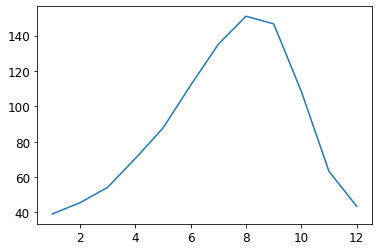

In [56]:
w = xr.open_dataset('Dong2008MLD.nc')

savenam = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_regridrecalc.nc'
cdomask = xr.open_dataset(savenam)
ds = cdomask.tmaskb

mld_DONG = np.zeros([12])
for i in range(0,12):
    MLD = w.MLD[i,:,:].isel(lat=slice(25,60)).values
    weights = (cdomask.tmask.isel(lat=slice(25,60))).values
    MLD[np.where(np.isnan(MLD))] = 0
    weights[np.where(MLD == 0)] = 0

    mld_DONG[i] =(np.average(MLD, weights = weights))

mos = np.arange(1,13,1)
plt.figure()
plt.plot(mos, mld_DONG)


In [64]:
MLD = w.MLD[i,:,:].isel(lat=slice(24,61))
w.lat[25:60]


<xarray.DataArray 'lat' (lat: 35)>
array([-64.5, -63.5, -62.5, -61.5, -60.5, -59.5, -58.5, -57.5, -56.5, -55.5,
       -54.5, -53.5, -52.5, -51.5, -50.5, -49.5, -48.5, -47.5, -46.5, -45.5,
       -44.5, -43.5, -42.5, -41.5, -40.5, -39.5, -38.5, -37.5, -36.5, -35.5,
       -34.5, -33.5, -32.5, -31.5, -30.5])
Coordinates:
  * lat      (lat) float64 -64.5 -63.5 -62.5 -61.5 ... -33.5 -32.5 -31.5 -30.5

In [58]:
cdomask.tmask

<xarray.DataArray 'tmask' (lat: 180, lon: 360)>
array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [5.405259e+08, 5.405259e+08, 5.405259e+08, ..., 5.405259e+08,
        5.405259e+08, 5.405259e+08],
       [3.243814e+08, 3.243814e+08, 3.243814e+08, ..., 3.243814e+08,
        3.243814e+08, 3.243814e+08],
       [1.081381e+08, 1.081381e+08, 1.081381e+08, ..., 1.081381e+08,
        1.081381e+08, 1.081381e+08]])
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Attributes:
    units:      m2
    long_name:

In [59]:
df2.columns.tolist()

NameError: name 'df2' is not defined

In [ ]:
print(df2[(df2.Month == 1) & (df2.latitude == -30.5) & (df2.longitude == 0.5)])

   Month  latitude  longitude   MLDpd
0      1     -30.5        0.5  16.336


NameError: name 'result' is not defined

In [ ]:
tdf = df[(df['Month '] == 1)& (df['latitude '] >= -30.5) & (df['longitude   '] < 0.5)]# & (df['longitude   '] < 0.5)] 
tdf['MLDpd     ']

In [ ]:
savenam = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_regridrecalc.nc'
cdomask = xr.open_dataset(savenam)
cdo_mask = cdomask.tmask